# Single Species Classifier

We demonstrate the classification of bird species observed in the Mt Kenya ecosystem leveraging open source models. In particular we demonstrate the use of embeddings obtained from Google's [Bird Vocalization Classifier](https://www.kaggle.com/models/google/bird-vocalization-classifier) to train classifiers for the species observed.

In this notebook we use logistic regression and a multilayer perceptron to classify bird species from the Mt Kenya ecosystem using embeddings extracted from the bird vocalisation classifier as features.

In [1]:
import os
import json
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
# set the seed for reproducability
np.random.seed(1234)
random.seed(1234)

In [3]:
embeddings_dir = '../embeddings/'

In [4]:
embedding_files = os.listdir(embeddings_dir)

In [5]:
with open('../annotations/single_species_filenames.json', 'r') as fp:
    single_species_filenames = json.load(fp)
single_species_list = list(single_species_filenames.keys())
single_species_list = [s.replace('mp3','npz') for s in single_species_list]

## Features and labels

The 1280 dimensional embeddings are extracted from each of the 12 five second segments from the 1
minute long recordings and the mean of these embeddings are used as a feature for the recording.

In [6]:
labels = []
mean_embeddings = np.array([])
for embedding_file in single_species_list:
    labels.append(single_species_filenames[embedding_file.replace('npz', 'mp3')])
    npzfile = np.load(os.path.join(embeddings_dir, embedding_file))
    file_embeddings = npzfile['embeddings']

    if mean_embeddings.size:
        mean_embeddings = np.vstack((mean_embeddings, np.mean(file_embeddings, 0)))
    else:
        mean_embeddings = np.mean(file_embeddings, 0)

In [7]:
label_encoder = LabelEncoder()

In [8]:
label_indices = label_encoder.fit_transform(labels)

We use species with more than 10 recordings

In [9]:
label_counts = Counter(labels)
threshold = 10

filtered_labels = [label for label, count in label_counts.items() if count >= threshold]

In [10]:
filtered_labels

['Cinnamon Bracken Warbler',
 'Brown Woodland Warbler',
 'White-starred Robin',
 'Chestnut-throated Apalis',
 'Montane White-eye',
 'Mountain Yellow Warbler',
 "Hartlaub's Turaco",
 'Red-fronted Parrot',
 'Yellow-whiskered Greenbul']

In [11]:
len(label_counts)

35

In [12]:
new_labels = []
for label in labels:
    if label in filtered_labels:
        new_labels.append(label)
    else:
        new_labels.append('other')
        


In [13]:
Counter(new_labels)

Counter({'Brown Woodland Warbler': 225,
         'other': 65,
         'Chestnut-throated Apalis': 26,
         'Yellow-whiskered Greenbul': 24,
         'White-starred Robin': 16,
         'Red-fronted Parrot': 16,
         'Cinnamon Bracken Warbler': 14,
         'Mountain Yellow Warbler': 14,
         'Montane White-eye': 12,
         "Hartlaub's Turaco": 12})

In [14]:
len(Counter(new_labels))

10

# MLP Example - Figure 8 Confusion Matrix

In [15]:
X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, new_labels, test_size=0.2, random_state=123)

In [16]:
Counter(y_test)

Counter({'Brown Woodland Warbler': 52,
         'other': 11,
         'Mountain Yellow Warbler': 4,
         'Chestnut-throated Apalis': 4,
         'Red-fronted Parrot': 4,
         'Yellow-whiskered Greenbul': 3,
         'Montane White-eye': 3,
         'White-starred Robin': 2,
         'Cinnamon Bracken Warbler': 1,
         "Hartlaub's Turaco": 1})

In [17]:
classifier = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(200,100))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [18]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.93


In [19]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [20]:
accuracy

0.7647058823529411

In [21]:
species_codes = []
for cl in classifier.classes_:
    names = cl.split()
    if len(names) == 2:
        species_codes.append(names[0][:2].upper() + names[1][:2].upper()) 
    elif len(names) == 3:
        species_codes.append(names[0][:1].upper() + names[1][:1].upper() + names[2][:2].upper())
    else:
        species_codes.append(cl)

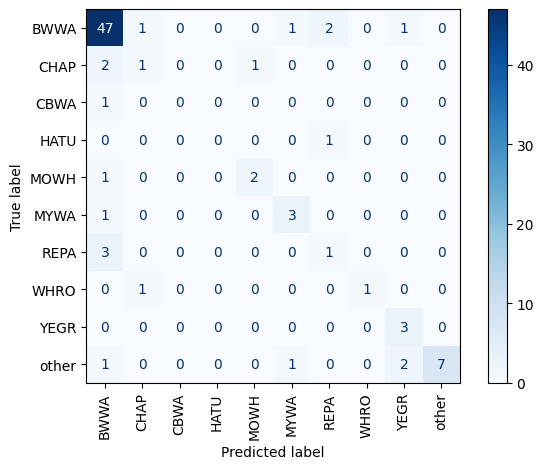

In [22]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_codes)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('cm-mlp.jpg', dpi=300)

# Logistic Regression

We determine the performance with logistic regression for 100 trials. The results are in Table 10.

In [23]:
num_trial = 2
trial = 0
classifier = LogisticRegression(max_iter=500)
np.random.seed(123)

lr_auc = []
lr_acc = []
while trial < num_trial:
    X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, new_labels, test_size=0.2)

    if len(Counter(y_test)) == len(Counter(new_labels)) and len(Counter(y_train)) == len(Counter(new_labels)):
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        macro_roc_auc_ovr = roc_auc_score(
                                y_test,
                                y_score,
                                multi_class="ovr",
                                average="macro",
                            )
                            
        #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")
        
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        lr_auc.append(macro_roc_auc_ovr)
        lr_acc.append(accuracy)

        trial += 1

print('Mean AUC: {}, Mean Accuracy {}'.format(np.mean(lr_auc), np.mean(lr_acc)))
        

Mean AUC: 0.9142015361238287, Mean Accuracy 0.7


# MLP

We determine the performance with a multilayer perceptron for 100 trials. The results are in Table 10.

In [24]:
num_trial = 20
trial = 0
classifier = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(200,100))
np.random.seed(123)

mlp_auc = []
mlp_acc = []
while trial < num_trial:
    X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, new_labels, test_size=0.2)

    if len(Counter(y_test)) == len(Counter(new_labels)) and len(Counter(y_train)) == len(Counter(new_labels)):
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        macro_roc_auc_ovr = roc_auc_score(
                                y_test,
                                y_score,
                                multi_class="ovr",
                                average="macro",
                            )
                            
        #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")
        
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        mlp_auc.append(macro_roc_auc_ovr)
        mlp_acc.append(accuracy)

        trial += 1

print('Mean AUC: {}, Mean Accuracy {}'.format(np.mean(mlp_auc), np.mean(mlp_acc)))
        

Mean AUC: 0.8939626580085662, Mean Accuracy 0.6876470588235293
